In [ ]:
%reload_ext autoreload
%autoreload 2
from data import extract_split_data, make_kfold_splits
from AM_POD import PolynomialManifoldApproximation
from tqdm import tqdm
import numpy as np
import time

# 1) Load the train split and build 5 folds
inputs, outputs = extract_split_data("train")
folds = make_kfold_splits(inputs, outputs, n_splits=5, random_state=42)

In [ ]:
# 2) Define the grid of (polynomial_order, r) to search
param_grid = [(p, r) for p in [1, 2, 3] for r in [5, 10, 15, 20, 25, 30, 35, 40]]

results_mach = {}
all_errors = []
print("=== Searching best parameters for MACH ===")
for poly_order, r in param_grid:
    print(f"Testing polynomial_order={poly_order}, r={r} for MACH")
    t0 = time.time()
    fold_errors = []

    with tqdm(
        total=len(folds), desc=f"  MACH p={poly_order}, r={r}", leave=False
    ) as pbar:
        for fold_idx, (train_in, train_out, val_in, val_out) in enumerate(folds):
            # prepare snapshots for mach
            S_train = np.stack(train_out["mach"], axis=0)
            S_val = np.stack(val_out["mach"], axis=0)

            pma = PolynomialManifoldApproximation(
                polynomial_order=poly_order,
                r=r,
            )
            pma.fit(S_train, S_val)
            err = pma.score(S_val)
            fold_errors.append(err)

            # update the tqdm bar
            avg_err = np.mean(fold_errors)
            pbar.set_postfix({"last_err": f"{err:.4e}", "avg_err": f"{avg_err:.4e}"})
            pbar.update()

            all_errors.append(
                {"poly_order": poly_order, "r": r, "fold": fold_idx, "error": err}
            )

    avg_err = np.mean(fold_errors)
    elapsed = time.time() - t0
    results_mach[(poly_order, r)] = avg_err
    print(
        f"--> Done p={poly_order}, r={r}: avg_error={avg_err:.4f} (time {elapsed:.1f}s)"
    )
    print("_" * 80)

best_mach = min(results_mach, key=results_mach.get)
print(
    f"\nBest for MACH → polynomial_order={best_mach[0]}, r={best_mach[1]} "
    f"(avg_val_error={results_mach[best_mach]:.4f})"
)

=== Searching best parameters for MACH ===
Testing polynomial_order=1, r=5 for MACH


--> Done p=1, r=5: avg_error=0.0935 (time 19.0s)
________________________________________________________________________________
Testing polynomial_order=1, r=10 for MACH


--> Done p=1, r=10: avg_error=0.0414 (time 5.8s)
________________________________________________________________________________
Testing polynomial_order=1, r=15 for MACH


--> Done p=1, r=15: avg_error=0.0267 (time 6.3s)
________________________________________________________________________________
Testing polynomial_order=1, r=20 for MACH


--> Done p=1, r=20: avg_error=0.0202 (time 7.5s)
________________________________________________________________________________
Testing polynomial_order=1, r=25 for MACH


--> Done p=1, r=25: avg_error=0.0162 (time 28.4s)
________________________________________________________________________________
Testing polynomial_order=1, r=30 for MACH


--> Done p=1, r=30: avg_error=0.0130 (time 23.6s)
________________________________________________________________________________
Testing polynomial_order=1, r=35 for MACH


  MACH p=1, r=35:  20%|██        | 1/5 [00:04<00:16,  4.13s/it, last_err=1.0481e-02, avg_err=1.0481e-02]

In [ ]:
from utils import CVResults

results_mach = CVResults(all_errors)
results_mach.print_summary()


Per‑fold errors with average and maximum (scientific notation):

fold                   0          1          2          3          4  \
poly_order r                                                           
1          5  8.9004e-02 8.2217e-02 9.3112e-02 1.1030e-01 9.2646e-02   
           10 4.1361e-02 3.4713e-02 4.0211e-02 5.2958e-02 3.7600e-02   
           15 2.5869e-02 2.1174e-02 2.5666e-02 3.7416e-02 2.3457e-02   
           20 1.9254e-02 1.5128e-02 1.8829e-02 3.0590e-02 1.6993e-02   
2          5  4.0270e-02 1.8629e-02 2.6218e-02 4.6987e-02 4.7055e-02   
           10 7.4365e-04 6.1681e-03 2.6023e-03 5.8642e-03 5.6249e-04   
           15 2.1852e-03 3.6775e-04 5.3588e-03 1.4281e-02 5.2613e-03   
           20 2.2369e-02 1.6533e-02 2.5168e-02 1.9361e-01 3.6405e-02   
3          5  1.6974e-04 1.0169e-04 3.0213e-04 2.7330e-04 8.5393e-04   
           10 1.6082e-01 9.7447e-02 3.0617e-01 3.0906e-01 1.7390e-01   
           15 1.9859e+00 1.0727e+00 1.9196e+00 5.5573e+00 2.2958e+00  

In [ ]:
# 2) Define the grid of (polynomial_order, r) to search
param_grid = [(p, r) for p in [1, 2, 3] for r in [5, 10, 15, 20, 25, 30, 35, 40]]

# 3b) Search best params for 'nut'
results_nut = {}
all_errors_nut = []

print("=== Searching best parameters for NUT ===")
for poly_order, r in param_grid:
    print(f"\nTesting polynomial_order={poly_order}, r={r} for NUT")
    t0 = time.time()
    fold_errors = []

    with tqdm(
        total=len(folds), desc=f"  NUT p={poly_order}, r={r}", leave=False
    ) as pbar:
        for fold_idx, (train_in, train_out, val_in, val_out) in enumerate(folds):
            # prepare snapshots for nut
            S_train = np.stack(train_out["nut"], axis=0)
            S_val = np.stack(val_out["nut"], axis=0)

            pma = PolynomialManifoldApproximation(
                polynomial_order=poly_order,
                r=r,
                reg_ls=0.001,
            )
            pma.fit(S_train, S_val)
            err = pma.score(S_val)
            fold_errors.append(err)

            # update the tqdm bar
            avg_err = np.mean(fold_errors)
            pbar.set_postfix({"last_err": f"{err:.4e}", "avg_err": f"{avg_err:.4e}"})
            pbar.update()

            all_errors_nut.append(
                {"poly_order": poly_order, "r": r, "fold": fold_idx, "error": err}
            )

    avg_err = np.mean(fold_errors)
    elapsed = time.time() - t0
    results_nut[(poly_order, r)] = avg_err
    print(
        f"--> Done p={poly_order}, r={r}: avg_error={avg_err:.4f} (time {elapsed:.1f}s)"
    )
    print("_" * 80)

best_nut = min(results_nut, key=results_nut.get)
print(
    f"\nBest for NUT → polynomial_order={best_nut[0]}, r={best_nut[1]} "
    f"(avg_val_error={results_nut[best_nut]:.4f})"
)

=== Searching best parameters for NUT ===

Testing polynomial_order=1, r=5 for NUT


--> Done p=1, r=5: avg_error=0.0575 (time 9.0s)
________________________________________________________________________________

Testing polynomial_order=1, r=10 for NUT


--> Done p=1, r=10: avg_error=0.0284 (time 6.6s)
________________________________________________________________________________

Testing polynomial_order=1, r=15 for NUT


--> Done p=1, r=15: avg_error=0.0172 (time 6.0s)
________________________________________________________________________________

Testing polynomial_order=1, r=20 for NUT


--> Done p=1, r=20: avg_error=0.0113 (time 6.0s)
________________________________________________________________________________

Testing polynomial_order=1, r=25 for NUT


--> Done p=1, r=25: avg_error=0.0092 (time 6.5s)
________________________________________________________________________________

Testing polynomial_order=1, r=30 for NUT


--> Done p=1, r=30: avg_error=0.0072 (time 6.6s)
________________________________________________________________________________

Testing polynomial_order=1, r=35 for NUT


--> Done p=1, r=35: avg_error=0.0060 (time 7.0s)
________________________________________________________________________________

Testing polynomial_order=1, r=40 for NUT


--> Done p=1, r=40: avg_error=0.0051 (time 7.2s)
________________________________________________________________________________

Testing polynomial_order=2, r=5 for NUT


--> Done p=2, r=5: avg_error=0.0553 (time 637.1s)
________________________________________________________________________________

Testing polynomial_order=2, r=10 for NUT


--> Done p=2, r=10: avg_error=0.0275 (time 181.6s)
________________________________________________________________________________

Testing polynomial_order=2, r=15 for NUT


--> Done p=2, r=15: avg_error=0.0171 (time 67.6s)
________________________________________________________________________________

Testing polynomial_order=2, r=20 for NUT


--> Done p=2, r=20: avg_error=0.0112 (time 58.5s)
________________________________________________________________________________

Testing polynomial_order=2, r=25 for NUT


--> Done p=2, r=25: avg_error=0.0091 (time 53.7s)
________________________________________________________________________________

Testing polynomial_order=2, r=30 for NUT


--> Done p=2, r=30: avg_error=0.0072 (time 44.9s)
________________________________________________________________________________

Testing polynomial_order=2, r=35 for NUT


--> Done p=2, r=35: avg_error=0.0060 (time 47.0s)
________________________________________________________________________________

Testing polynomial_order=2, r=40 for NUT


--> Done p=2, r=40: avg_error=0.0051 (time 38.2s)
________________________________________________________________________________

Testing polynomial_order=3, r=5 for NUT


--> Done p=3, r=5: avg_error=0.0552 (time 653.5s)
________________________________________________________________________________

Testing polynomial_order=3, r=10 for NUT


--> Done p=3, r=10: avg_error=0.0275 (time 199.2s)
________________________________________________________________________________

Testing polynomial_order=3, r=15 for NUT


--> Done p=3, r=15: avg_error=0.0171 (time 88.9s)
________________________________________________________________________________

Testing polynomial_order=3, r=20 for NUT


--> Done p=3, r=20: avg_error=0.0112 (time 98.9s)
________________________________________________________________________________

Testing polynomial_order=3, r=25 for NUT


--> Done p=3, r=25: avg_error=0.0091 (time 122.6s)
________________________________________________________________________________

Testing polynomial_order=3, r=30 for NUT


--> Done p=3, r=30: avg_error=0.0072 (time 224.8s)
________________________________________________________________________________

Testing polynomial_order=3, r=35 for NUT


--> Done p=3, r=35: avg_error=0.0060 (time 753.9s)
________________________________________________________________________________

Testing polynomial_order=3, r=40 for NUT


--> Done p=3, r=40: avg_error=0.0051 (time 1287.4s)
________________________________________________________________________________

Best for NUT → polynomial_order=3, r=40 (avg_val_error=0.0051)


In [ ]:
results_nut = CVResults(all_errors_nut)
results_nut.print_summary()


Per‑fold errors with average and maximum (scientific notation):

fold                   0          1          2          3          4  \
poly_order r                                                           
1          5  4.6068e-02 4.8334e-02 5.5693e-02 8.4863e-02 5.2538e-02   
           10 1.9472e-02 2.0001e-02 2.4786e-02 5.3352e-02 2.4315e-02   
           15 1.1241e-02 1.0537e-02 1.3095e-02 3.7597e-02 1.3710e-02   
           20 7.1576e-03 6.7777e-03 8.7519e-03 2.5766e-02 7.9970e-03   
           25 5.7165e-03 5.1691e-03 6.8905e-03 2.1623e-02 6.4547e-03   
           30 4.4221e-03 3.9877e-03 5.3821e-03 1.7494e-02 4.9012e-03   
           35 3.6617e-03 3.1752e-03 4.4125e-03 1.4677e-02 4.0036e-03   
           40 2.9753e-03 2.6142e-03 3.6985e-03 1.2834e-02 3.3316e-03   
2          5  4.4859e-02 4.4850e-02 5.3300e-02 8.3814e-02 4.9537e-02   
           10 1.9287e-02 1.9436e-02 2.3611e-02 5.1615e-02 2.3690e-02   
           15 1.1221e-02 1.0473e-02 1.2856e-02 3.7242e-02 1.3680e-02  

In [ ]:
%reload_ext autoreload
%autoreload 2
from processor import InputProcessor, OutputProcessor

inputprocessor = InputProcessor(explained_variance=0.99999)
X = inputprocessor.fit_transform(inputs)

In [ ]:
print(inputprocessor.n_components_)

13


In [ ]:
outputprocessor = OutputProcessor(
    mach_params=(3, 5), nut_params=(1, 40), verbose=True, max_iter_rot=22
)
Y = outputprocessor.fit_transform(outputs)

POD computed cumulated expected variance : 0.8587
---> compute polynomial correction 1.5051 seconds
---> pod 9.0654e-02 vs polynomial 2.6066e-02 vs AM-polynomial 2.6066e-02
initialization completed
AM iteration 0
---> solve procrustes problem in 5.7931 seconds
---> solve levenberg marquardt problem in 4.6104 seconds
---> least square problem solved in 0.3463 seconds
---> pod 9.0654e-02 vs polynomial 2.6066e-02 vs AM-polynomial 1.8594e-02
AM iteration 1
---> solve procrustes problem in 3.3165 seconds
---> solve levenberg marquardt problem in 3.4221 seconds
---> least square problem solved in 0.3408 seconds
---> pod 9.0654e-02 vs polynomial 2.6066e-02 vs AM-polynomial 1.8138e-02
AM iteration 2
---> solve procrustes problem in 1.0208 seconds
---> solve levenberg marquardt problem in 4.8040 seconds
---> least square problem solved in 0.2335 seconds
---> pod 9.0654e-02 vs polynomial 2.6066e-02 vs AM-polynomial 1.7762e-02
AM iteration 3
---> solve procrustes problem in 1.0774 seconds
---> so

In [ ]:
from model import GPyRegressor

# one single GP
gpmodel = GPyRegressor()
gpmodel.fit(X, Y)

[2025-05-15 10:04:01,212:INFO:gp.py:__init__(47)]:initializing Y
[2025-05-15 10:04:01,213:INFO:gp.py:__init__(96)]:initializing inference method
[2025-05-15 10:04:01,213:INFO:gp.py:__init__(105)]:adding kernel and likelihood as parameters


Optimization restart 1/5, f = 39535.071576112474
Optimization restart 2/5, f = 39410.32995777087
Optimization restart 3/5, f = 39410.37690555092
Optimization restart 4/5, f = 39535.0869702242
Optimization restart 5/5, f = 39410.443795230196


GPyRegressor()

In [ ]:
inputs_test, outputs_test = extract_split_data("test")

In [ ]:
X_test = inputprocessor.transform(inputs_test)
Y_test = gpmodel.predict(X_test)
outputs_test_pred = outputprocessor.inverse_transform(Y_test)

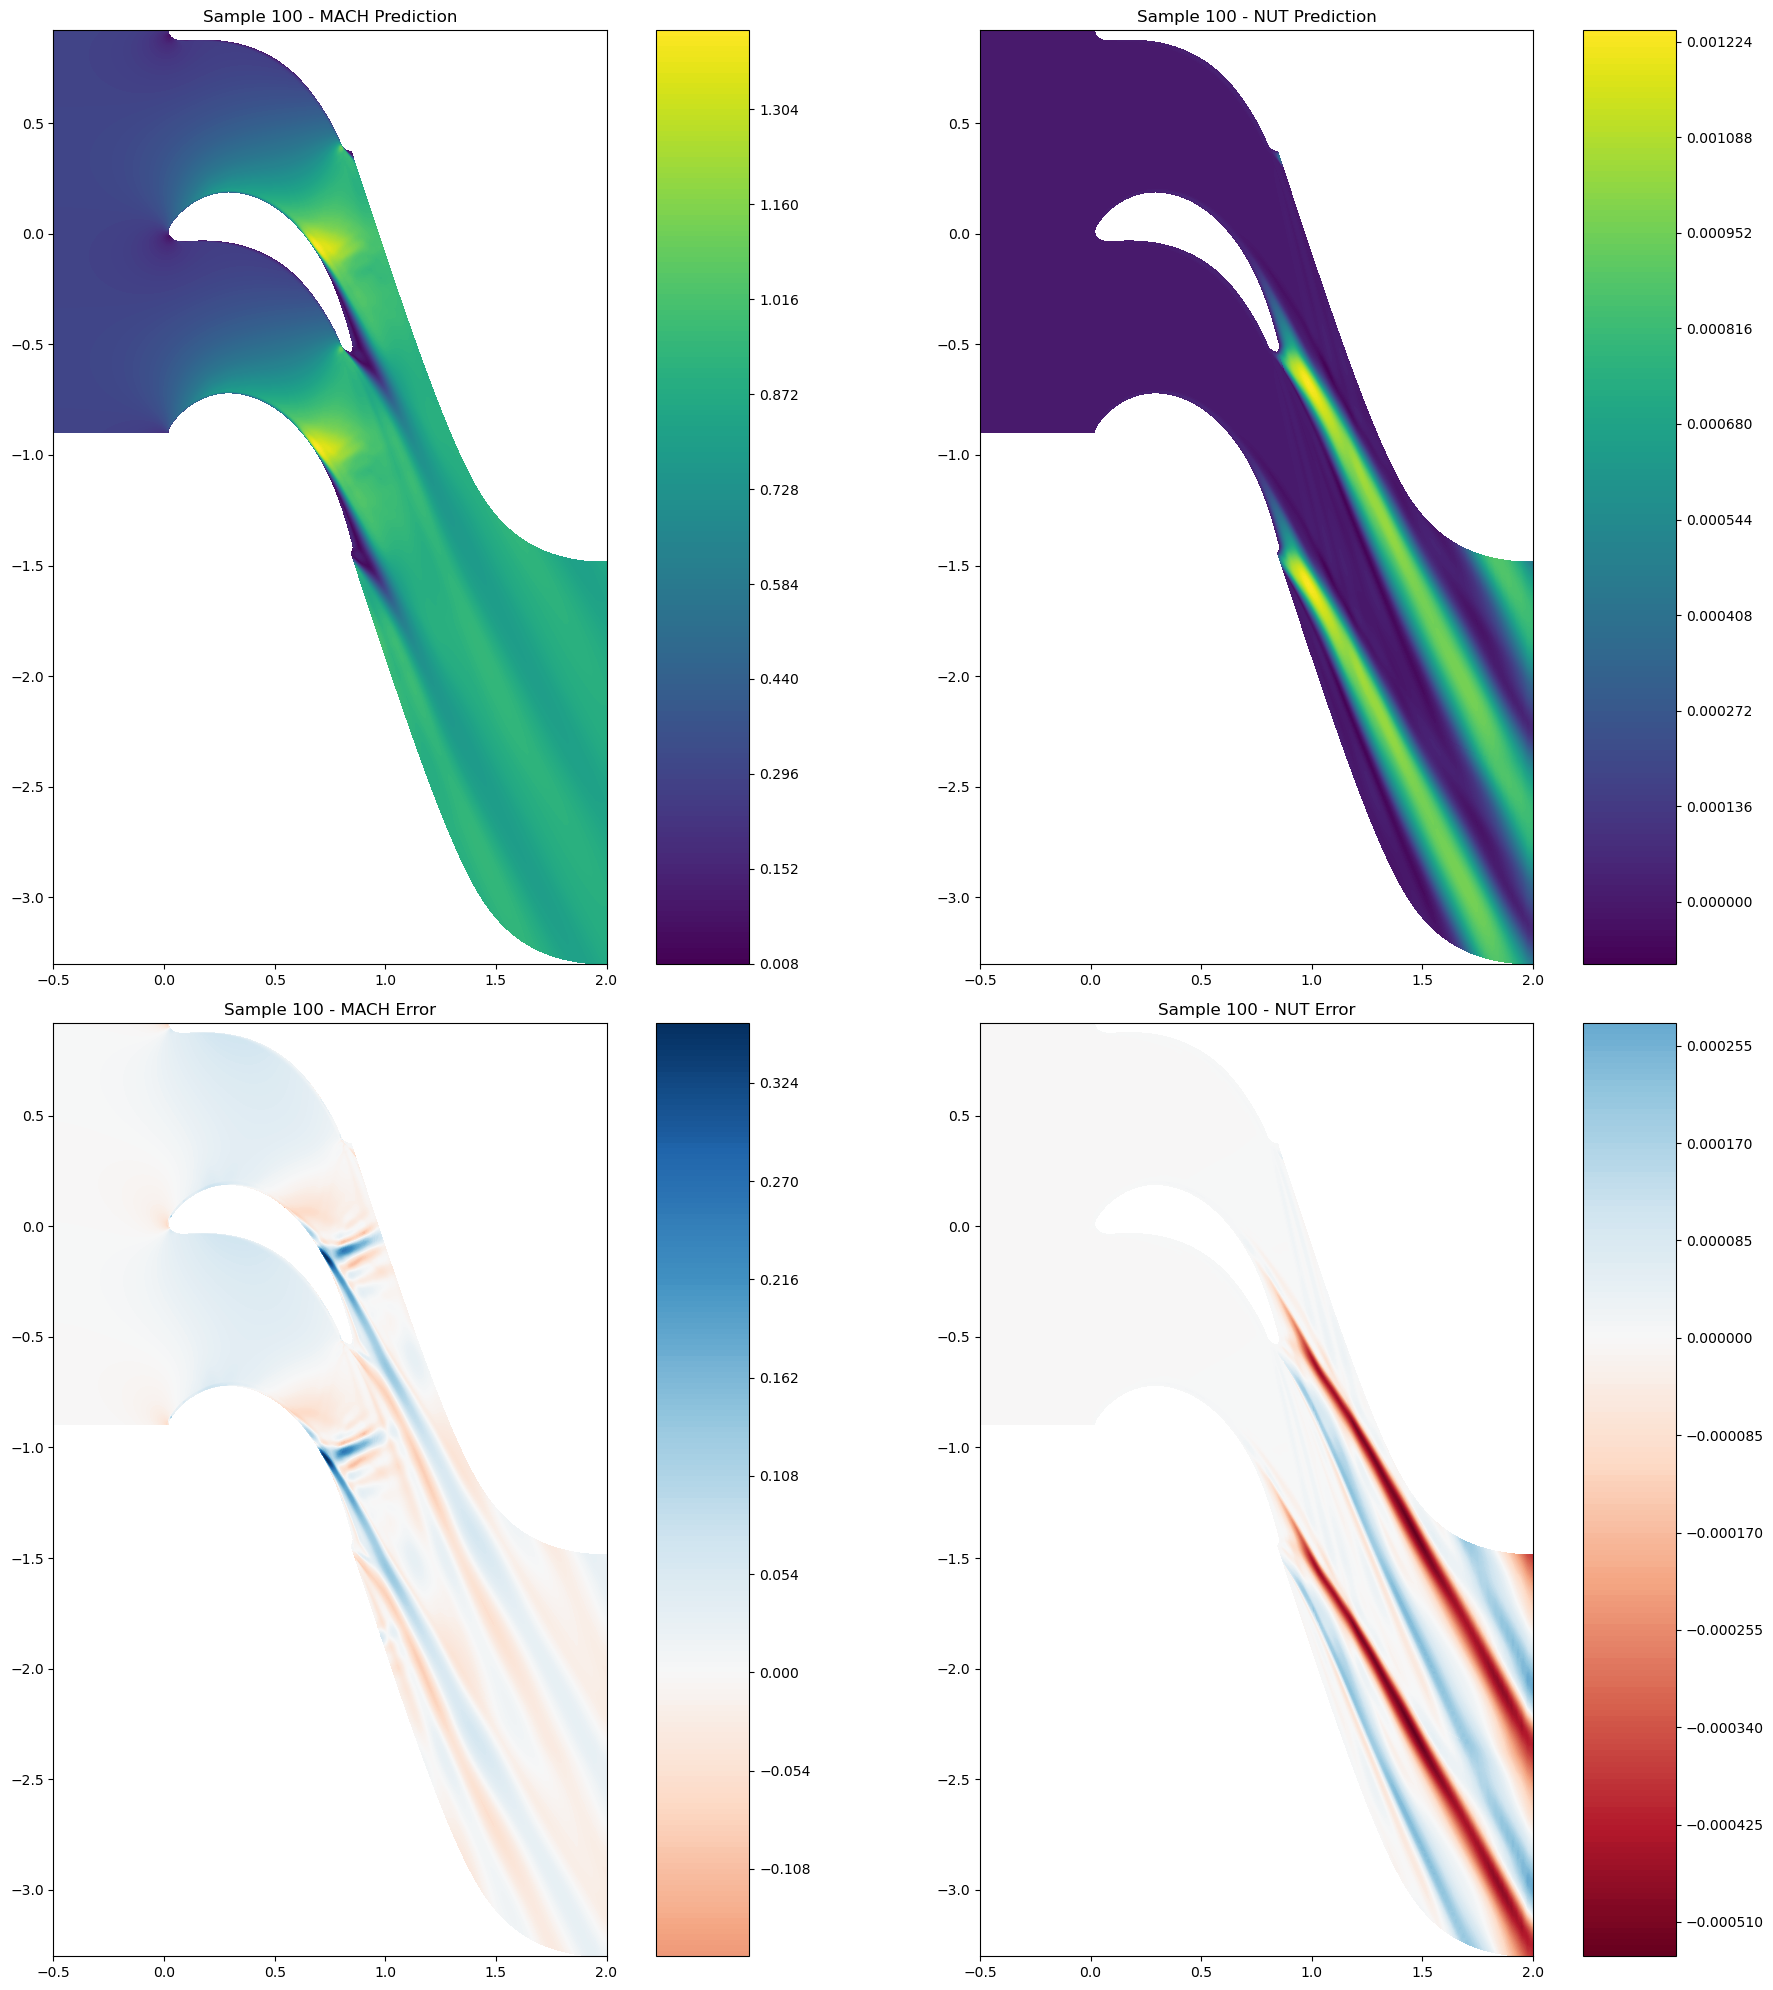

In [ ]:
import matplotlib.pyplot as plt
from utils import plot_mach_nut, plot_scalars_pred_vs_true

fig, axs = plot_mach_nut(inputs_test, outputs_test, outputs_test_pred, idx=100)
plt.show()

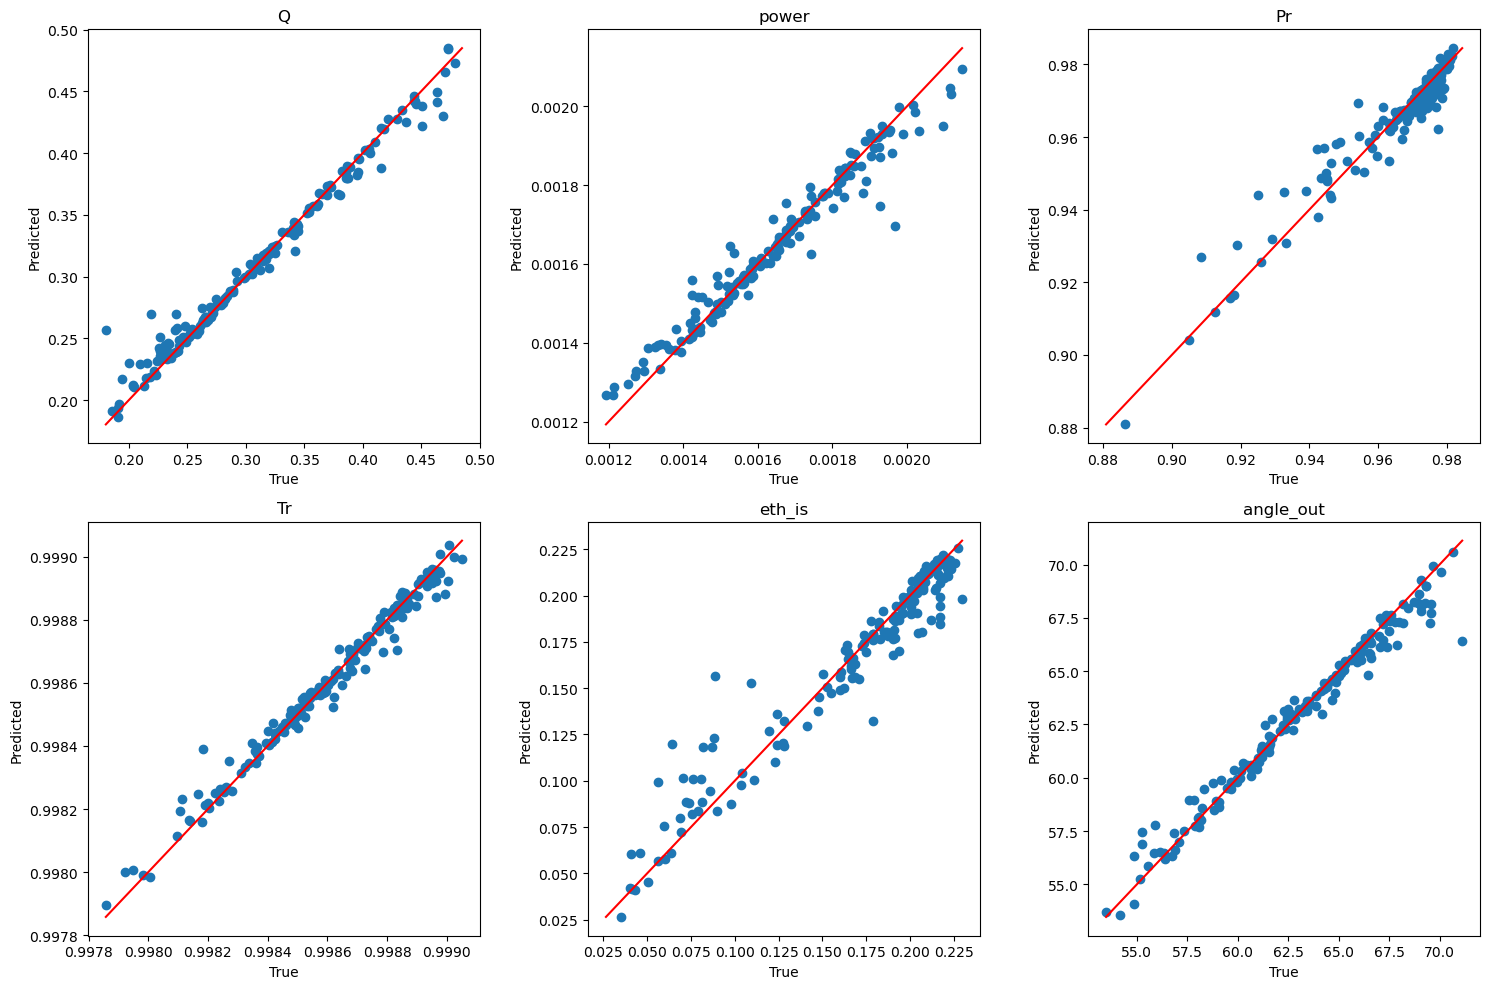

In [ ]:
fig, axs = plot_scalars_pred_vs_true(outputs_test, outputs_test_pred)

In [ ]:
from data import dump_predictions

dump_predictions(outputs_test_pred, "predictions.pkl")

Predictions successfully dumped to 'predictions.pkl'


In [ ]:
from tabnanny import verbose
from joblib import Parallel, delayed
from model import GPyRegressor


def train_single_output(X, y):
    gp = GPyRegressor()
    gp.fit(X, y)
    return gp


# X: (n_samples, n_features)
# Y: (n_samples, n_outputs)
n_outputs = Y.shape[1]

# Parallel training: use all cores (n_jobs=-1), and print progress (verbose=10)
gp_models = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_single_output)(X, Y[:, j]) for j in range(n_outputs)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Optimization restart 1/5, f = 744.668448882174
Optimization restart 1/5, f = 873.9844207443022
Optimization restart 1/5, f = 824.0464876137393


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract


Optimization restart 1/5, f = 884.8563318150386
Optimization restart 1/5, f = 684.3464844914391
Optimization restart 1/5, f = 805.2689169532038
Optimization restart 1/5, f = 868.2848360570806
Optimization restart 1/5, f = 783.9781952902772
Optimization restart 1/5, f = 524.5554930902902
Optimization restart 1/5, f = 263.877608439165
Optimization restart 1/5, f = 727.149707557265
Optimization restart 1/5, f = 836.4313192257381
Optimization restart 1/5, f = 385.11509736809273
Optimization restart 1/5, f = 878.5229512099859
Optimization restart 1/5, f = 176.04030338403243
Optimization restart 2/5, f = 873.9844198062858
Optimization restart 1/5, f = 620.9265135814583
Optimization restart 1/5, f = 814.3406977747559
Optimization restart 2/5, f = 744.6569449083661
Optimization restart 2/5, f = 824.0471006860671


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract


Optimization restart 1/5, f = 752.1755030207945
Optimization restart 2/5, f = 884.8563413512334
Optimization restart 2/5, f = 530.742590489496
Optimization restart 2/5, f = 868.2848412916906


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


Optimization restart 2/5, f = 726.8366487014955
Optimization restart 1/5, f = 795.191165956069
Optimization restart 1/5, f = 605.1344731771949
Optimization restart 1/5, f = 868.4744245769034
Optimization restart 3/5, f = 873.984437620948
Optimization restart 1/5, f = 863.2056118689188
Optimization restart 2/5, f = 814.2710611782904
Optimization restart 1/5, f = -591.231163549493
Optimization restart 2/5, f = 805.0156747899492
Optimization restart 2/5, f = 881.9143549236856
Optimization restart 2/5, f = 682.2019925329023
Optimization restart 1/5, f = 362.83037733497906
Optimization restart 3/5, f = 884.8563271169061
Optimization restart 1/5, f = -286.12628030128303
Optimization restart 3/5, f = 823.8927949374981
Optimization restart 3/5, f = 727.8709169572924
Optimization restart 2/5, f = 263.87135624272645
Optimization restart 3/5, f = 870.1030040580742
Optimization restart 2/5, f = 606.2457618637699
Optimization restart 4/5, f = 873.9844190981014


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


Optimization restart 2/5, f = 620.9265240774355
Optimization restart 2/5, f = 836.4313270044075
Optimization restart 2/5, f = 175.97655451874704
Optimization restart 1/5, f = 852.506663521005
Optimization restart 2/5, f = 783.475594806021
Optimization restart 3/5, f = 744.6734330764019
Optimization restart 2/5, f = 868.4744256137051
Optimization restart 2/5, f = 385.11496673400643
Optimization restart 2/5, f = 752.1753638946363
Optimization restart 3/5, f = 687.8212091102998
Optimization restart 1/5, f = 180.91221798976096
Optimization restart 1/5, f = -34.55549559621443
Optimization restart 3/5, f = 524.5555038649733
Optimization restart 3/5, f = 805.2886776371706
Optimization restart 5/5, f = 873.9844196483741
Optimization restart 3/5, f = 813.1155919544788
Optimization restart 4/5, f = 824.0470817822367
Optimization restart 4/5, f = 868.284835419023
Optimization restart 4/5, f = 884.856328889629Optimization restart 3/5, f = 606.2632716343531

Optimization restart 4/5, f = 729.495406

[Parallel(n_jobs=-1)]: Done   6 out of  51 | elapsed:   35.1s remaining:  4.4min


Optimization restart 2/5, f = 875.5237863439654
Optimization restart 3/5, f = 863.2055453504283
Optimization restart 4/5, f = 836.4313587538329
Optimization restart 1/5, f = -249.05846800731172
Optimization restart 1/5, f = 860.3905130457836
Optimization restart 4/5, f = 605.1344659517823
Optimization restart 2/5, f = 852.5066401990064
Optimization restart 4/5, f = 620.8885761213699
Optimization restart 1/5, f = 879.1446515596289


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


Optimization restart 4/5, f = 775.4238386560244
Optimization restart 5/5, f = 813.1156052723691
Optimization restart 4/5, f = 869.0961432349598
Optimization restart 1/5, f = 933.0056499960281
Optimization restart 5/5, f = 878.5224567060911
Optimization restart 1/5, f = 903.4205367552186
Optimization restart 3/5, f = 877.0967621876622
Optimization restart 4/5, f = 783.4926150802203
Optimization restart 5/5, f = 524.5554906011104
Optimization restart 2/5, f = 181.53869140837617
Optimization restart 4/5, f = 176.0403038398
Optimization restart 1/5, f = 932.6228688247273


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


Optimization restart 5/5, f = 805.0156780029313
Optimization restart 2/5, f = 860.3905135548043
Optimization restart 4/5, f = 384.7869356354994
Optimization restart 5/5, f = 837.4638715442212
Optimization restart 3/5, f = 795.1912838259241
Optimization restart 4/5, f = 863.2055226358559
Optimization restart 3/5, f = 362.7324568993963
Optimization restart 1/5, f = 910.5282935019272
Optimization restart 3/5, f = -591.2252274943645
Optimization restart 4/5, f = 875.5237345386968
Optimization restart 1/5, f = 908.7135080766501


[Parallel(n_jobs=-1)]: Done  12 out of  51 | elapsed:   47.1s remaining:  2.6min


Optimization restart 2/5, f = 932.9392259304502
Optimization restart 2/5, f = 933.0056445992996
Optimization restart 2/5, f = -283.3343543308454
Optimization restart 5/5, f = 752.1753782451988
Optimization restart 2/5, f = 879.1552321473678
Optimization restart 5/5, f = 176.0355698393746
Optimization restart 5/5, f = 869.096147073865
Optimization restart 4/5, f = 795.8793547832105
Optimization restart 5/5, f = 783.9755802009961
Optimization restart 1/5, f = 902.6900967184772
Optimization restart 5/5, f = 875.523741912703
Optimization restart 5/5, f = 622.7525755016522
Optimization restart 3/5, f = 860.6736767451
Optimization restart 2/5, f = -34.56237485883844
Optimization restart 4/5, f = 363.55852966275086
Optimization restart 3/5, f = 933.5322900613342
Optimization restart 5/5, f = 605.1345296916121
Optimization restart 1/5, f = 886.8127936984833
Optimization restart 1/5, f = 884.1723578967456
Optimization restart 1/5, f = 882.4373237265156
Optimization restart 2/5, f = 909.18748125

[Parallel(n_jobs=-1)]: Done  18 out of  51 | elapsed:   57.0s remaining:  1.7min


Optimization restart 5/5, f = 795.1911740992769
Optimization restart 3/5, f = 885.6396213924995
Optimization restart 1/5, f = 927.4736646785744
Optimization restart 2/5, f = -68.35499295617319
Optimization restart 3/5, f = 181.05900837610784
Optimization restart 2/5, f = -1131.1916399042714


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract


Optimization restart 1/5, f = 336.6520656289083
Optimization restart 2/5, f = 903.4244906227776
Optimization restart 2/5, f = 952.1076923703067
Optimization restart 4/5, f = 933.7738481563056
Optimization restart 5/5, f = 865.6769377275475
Optimization restart 4/5, f = 860.6736795354924
Optimization restart 4/5, f = 932.6228674255508
Optimization restart 4/5, f = -591.2188652588807
Optimization restart 2/5, f = 888.9402337040889
Optimization restart 5/5, f = 363.5813121573571
Optimization restart 1/5, f = -976.8795718994884
Optimization restart 2/5, f = 886.8127566931917
Optimization restart 2/5, f = 884.172332697192
Optimization restart 3/5, f = 911.116947573433
Optimization restart 5/5, f = 933.6721446532497
Optimization restart 5/5, f = 385.1149726621619


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract


Optimization restart 3/5, f = -286.1265688723249
Optimization restart 5/5, f = 860.6736748453684
Optimization restart 4/5, f = 879.0637341315186


[Parallel(n_jobs=-1)]: Done  24 out of  51 | elapsed:  1.2min remaining:  1.3min


Optimization restart 3/5, f = -34.5572544639939
Optimization restart 3/5, f = 887.9243050186261
Optimization restart 2/5, f = 901.742141110923
Optimization restart 3/5, f = 929.540675406411
Optimization restart 4/5, f = 268.8245970617347
Optimization restart 5/5, f = 936.7444173214527
Optimization restart 5/5, f = 879.1552354478292
Optimization restart 3/5, f = -68.0781386885343
Optimization restart 4/5, f = 910.7578030982704
Optimization restart 3/5, f = 888.4822741090271


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


Optimization restart 4/5, f = -255.4731021702866
Optimization restart 3/5, f = 849.6317532517721
Optimization restart 3/5, f = 903.5099321464555
Optimization restart 3/5, f = 907.457225348699
Optimization restart 4/5, f = 886.8128169529086
Optimization restart 2/5, f = -977.9227878889075
Optimization restart 3/5, f = 881.910187289099
Optimization restart 5/5, f = -591.2205569164959
Optimization restart 2/5, f = -249.05489921045296
Optimization restart 5/5, f = 910.5283052625093
Optimization restart 4/5, f = 942.3507989497682
Optimization restart 4/5, f = 917.3333350530205
Optimization restart 4/5, f = 890.1418476485715
Optimization restart 4/5, f = 181.08575066677605


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


Optimization restart 5/5, f = 266.37842954941937
Optimization restart 3/5, f = 904.7965513372817
Optimization restart 5/5, f = 886.8128185583095


[Parallel(n_jobs=-1)]: Done  30 out of  51 | elapsed:  1.4min remaining:   57.3s


Optimization restart 4/5, f = -34.54909884316788
Optimization restart 5/5, f = -284.8603035793134
Optimization restart 4/5, f = 903.4245163038878
Optimization restart 1/5, f = -1081.9629479931184
Optimization restart 1/5, f = -354.5607765936047
Optimization restart 4/5, f = 881.914578560709
Optimization restart 4/5, f = 904.3409940031235
Optimization restart 5/5, f = 882.4373210855139
Optimization restart 5/5, f = 935.0661112516486
Optimization restart 1/5, f = -1317.792317680408
Optimization restart 3/5, f = -976.873276896556
Optimization restart 4/5, f = -68.36722791343033
Optimization restart 4/5, f = 847.242053110018
Optimization restart 5/5, f = 908.7507598326724
Optimization restart 2/5, f = -1041.9657645784002
Optimization restart 3/5, f = -248.42575465308892
Optimization restart 5/5, f = 884.172313385293
Optimization restart 3/5, f = -1131.45125606764
Optimization restart 5/5, f = 903.4244594802942


[Parallel(n_jobs=-1)]: Done  36 out of  51 | elapsed:  1.5min remaining:   38.5s


Optimization restart 5/5, f = 902.8868327033223
Optimization restart 1/5, f = -2133.6376809141952
Optimization restart 5/5, f = 181.1242675924318
Optimization restart 1/5, f = -364.62006207032675
Optimization restart 2/5, f = -354.56078700467356


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


Optimization restart 4/5, f = -970.6216733338108
Optimization restart 5/5, f = -68.35500167545081
Optimization restart 5/5, f = 854.1560492590697
Optimization restart 4/5, f = -1129.3157926627193
Optimization restart 4/5, f = -248.9930921401516
Optimization restart 3/5, f = -1076.3723891774605
Optimization restart 5/5, f = -34.57257432902702


[Parallel(n_jobs=-1)]: Done  42 out of  51 | elapsed:  1.7min remaining:   22.3s


Optimization restart 2/5, f = -1317.7920859337917
Optimization restart 2/5, f = 336.6518921334414
Optimization restart 5/5, f = -976.8704432640103


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract


Optimization restart 3/5, f = -354.56068379964483
Optimization restart 2/5, f = -2133.5369206889727


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


Optimization restart 5/5, f = -1123.968703298719
Optimization restart 4/5, f = -1081.8968040932223
Optimization restart 3/5, f = -2083.9669842614862
Optimization restart 3/5, f = -1288.2722354988318


 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:586: RuntimeWarning:invalid value encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:589: RuntimeWarning:invalid value encountered in subtract
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /apps/ssa/automaticenvquantum/prod/envs/2dblade/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in multiply
 /apps/ssa/automaticenvquantum/prod/envs/2dbla

Optimization restart 2/5, f = -364.62049814671155
Optimization restart 3/5, f = 336.73954191918904
Optimization restart 4/5, f = -345.1639996965978
Optimization restart 4/5, f = -2133.6911619492575
Optimization restart 5/5, f = -1081.8975656624855
Optimization restart 4/5, f = -1317.7916476304956
Optimization restart 4/5, f = 336.68447089083986
Optimization restart 5/5, f = -248.84014644943613
Optimization restart 5/5, f = -1317.4264946255225
Optimization restart 5/5, f = -354.5605697414112


[Parallel(n_jobs=-1)]: Done  48 out of  51 | elapsed:  2.4min remaining:    8.8s


Optimization restart 5/5, f = -2133.68925038995
Optimization restart 3/5, f = -364.60468059441735
Optimization restart 5/5, f = 336.72718482137475
Optimization restart 4/5, f = -364.62108890444296
Optimization restart 5/5, f = -364.62128056785804


[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  3.2min finished


In [ ]:
len(gp_models)

51

In [ ]:
X_test = inputprocessor.transform(inputs_test)
Y_test = np.column_stack([gp.predict(X_test) for gp in gp_models])
outputs_test_pred = outputprocessor.inverse_transform(Y_test)

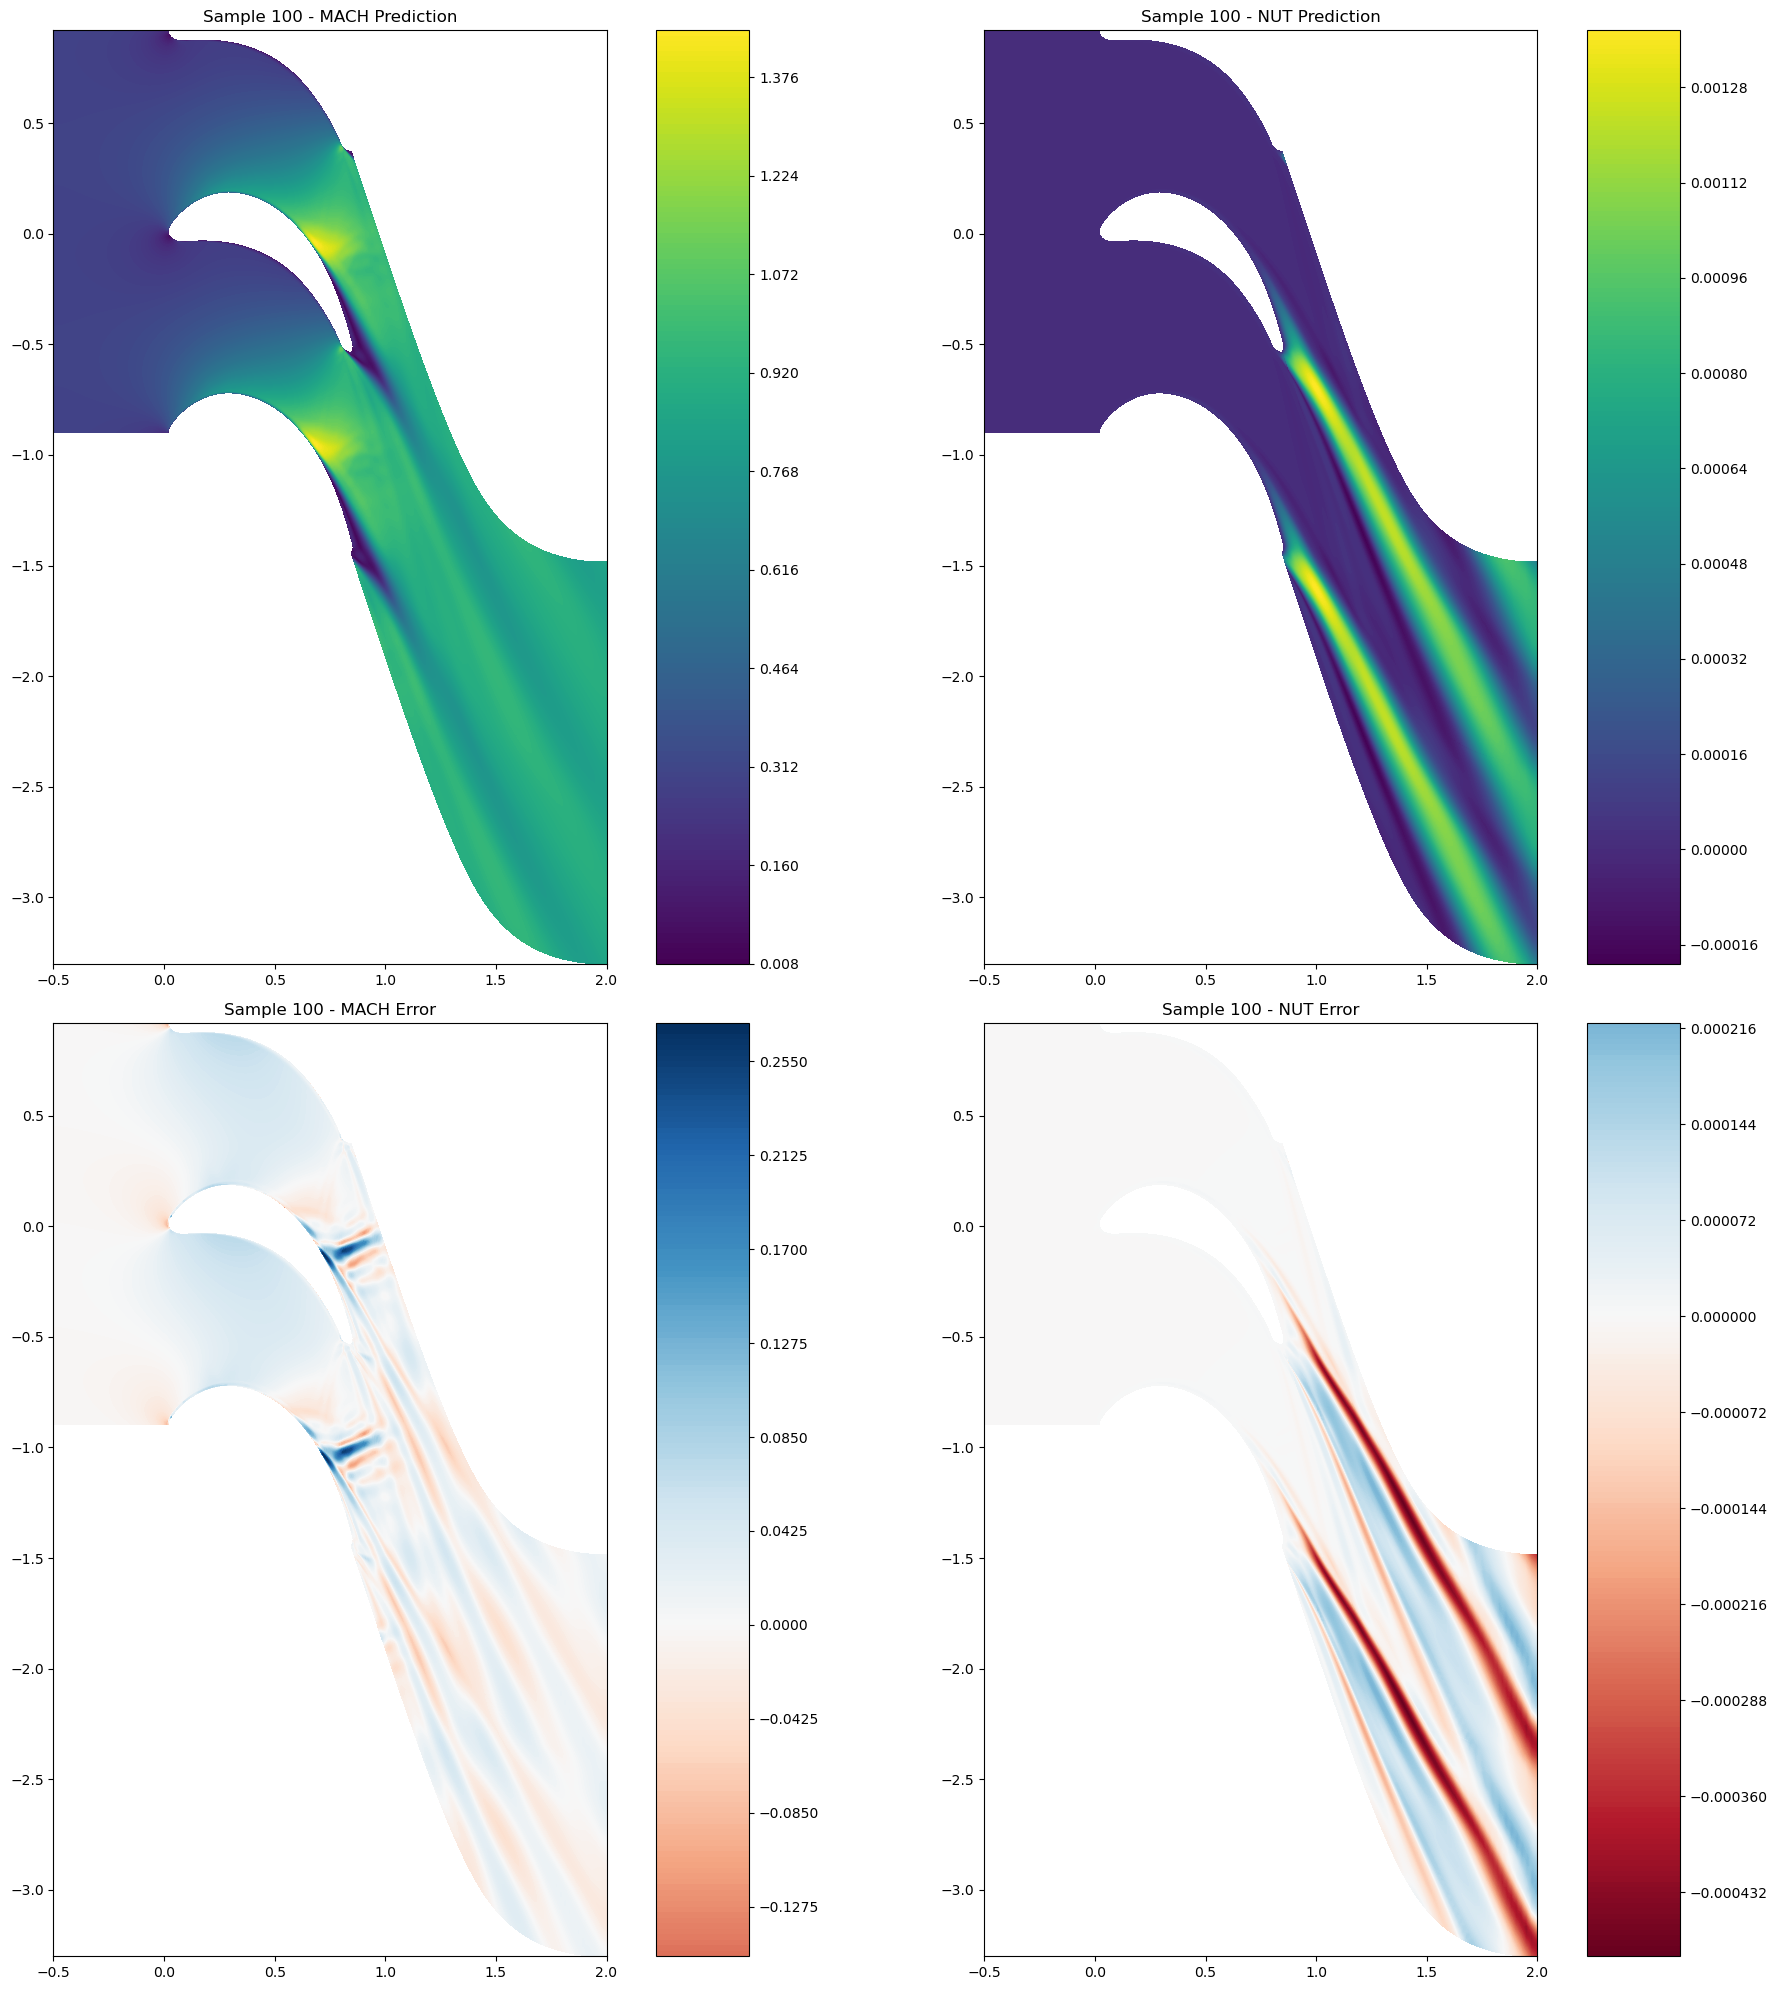

In [ ]:
import matplotlib.pyplot as plt
from utils import plot_mach_nut, plot_scalars_pred_vs_true

fig, axs = plot_mach_nut(inputs_test, outputs_test, outputs_test_pred, idx=100)

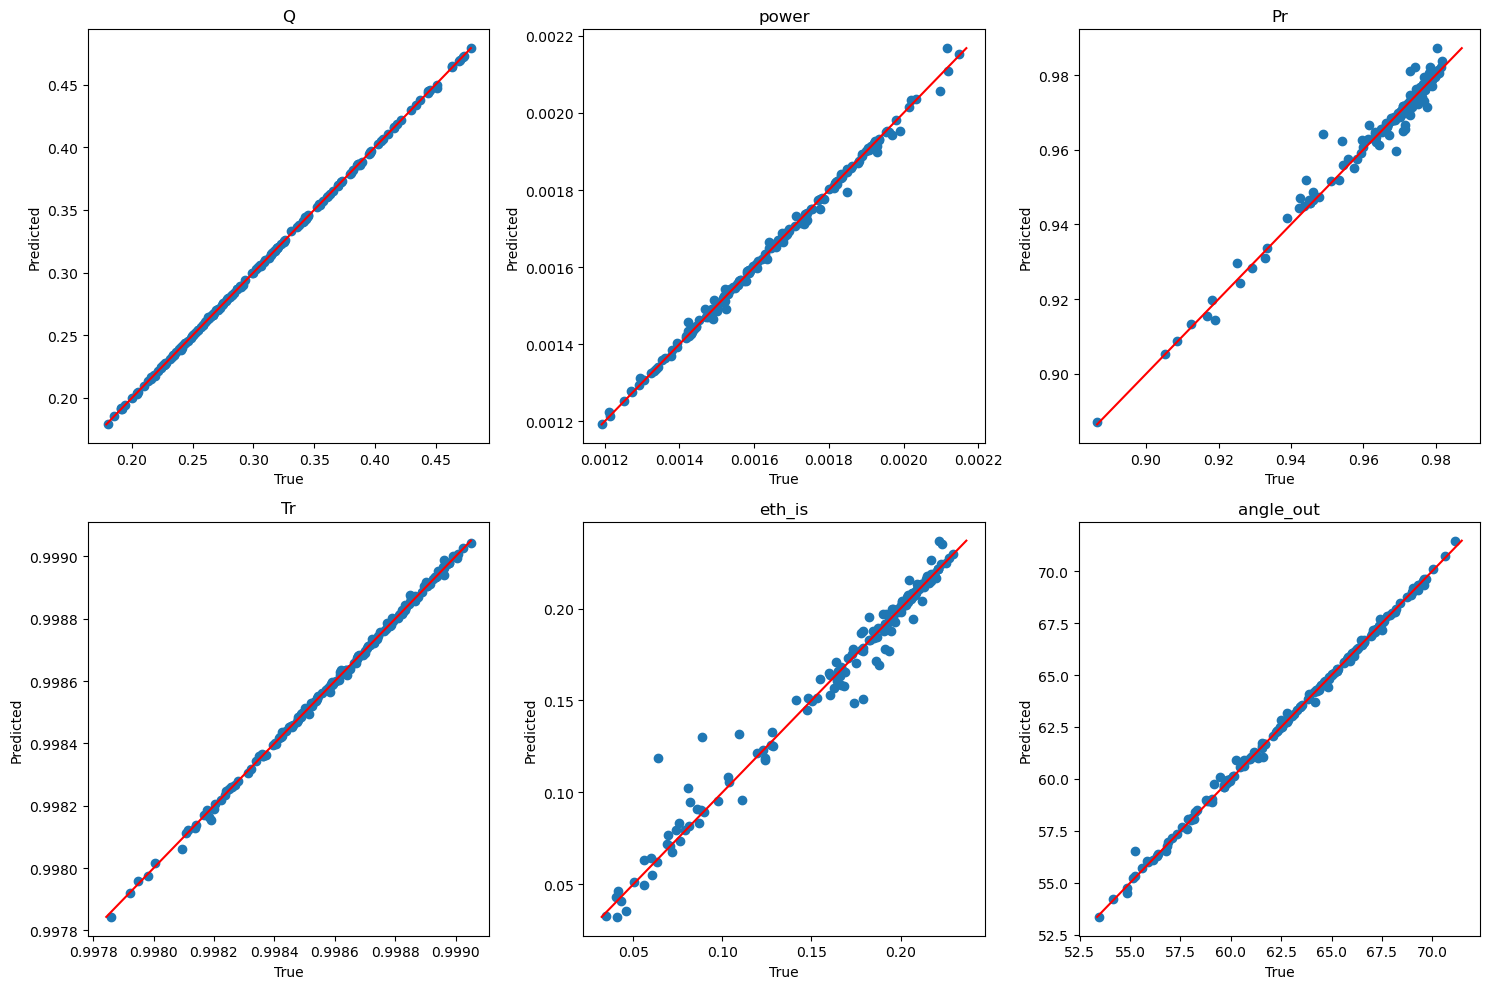

In [ ]:
fig, axs = plot_scalars_pred_vs_true(outputs_test, outputs_test_pred)

In [ ]:
from data import dump_predictions

dump_predictions(outputs_test_pred, "predictions.pkl")

Predictions successfully dumped to 'predictions.pkl'
